# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import string
import nltk
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

# Load the Data

In [2]:
df = pd.read_csv("/content/Combined_Jobs_Final.csv", engine='python', error_bad_lines=False)
df.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,Address,Latitude,Longitude,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,NaN,37.443346,-122.161170,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,NaN,37.789830,-122.404268,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,NaN,37.795597,-122.402963,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,NaN,37.685073,-122.400275,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,NaN,34.073384,-118.460439,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21292 entries, 0 to 21291
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job.ID              21292 non-null  int64  
 1   Provider            21292 non-null  int64  
 2   Status              21292 non-null  object 
 3   Slug                21292 non-null  object 
 4   Title               21292 non-null  object 
 5   Position            21292 non-null  object 
 6   Company             20510 non-null  object 
 7   City                21278 non-null  object 
 8   State.Name          21264 non-null  object 
 9   State.Code          21264 non-null  object 
 10  Address             15 non-null     object 
 11  Latitude            21292 non-null  float64
 12  Longitude           21292 non-null  float64
 13  Industry            106 non-null    object 
 14  Job.Description     21285 non-null  object 
 15  Requirements        0 non-null      float64
 16  Sala

# Exploratory Data Analysis
To check for null values

In [4]:
df.isnull().sum()

Job.ID                    0
Provider                  0
Status                    0
Slug                      0
Title                     0
Position                  0
Company                 782
City                     14
State.Name               28
State.Code               28
Address               21277
Latitude                  0
Longitude                 0
Industry              21186
Job.Description           7
Requirements          21292
Salary                21224
Listing.Start           554
Listing.End              38
Employment.Type          11
Education.Required      107
Created.At                1
Updated.At                1
dtype: int64

**Selecting the columns for job corpus**

In [5]:
cols = ['Job.ID']+['Title']+['Position']+ ['Company']+['City']+['Employment.Type']+['Job.Description']
df_new =df[cols]
df_new.columns = ['Job.ID', 'Title', 'Position', 'Company','City', 'Empl_type','Job_Description']
df_new.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [6]:
# checking for the null values again.
df_new.isnull().sum()

Job.ID               0
Title                0
Position             0
Company            782
City                14
Empl_type           11
Job_Description      7
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


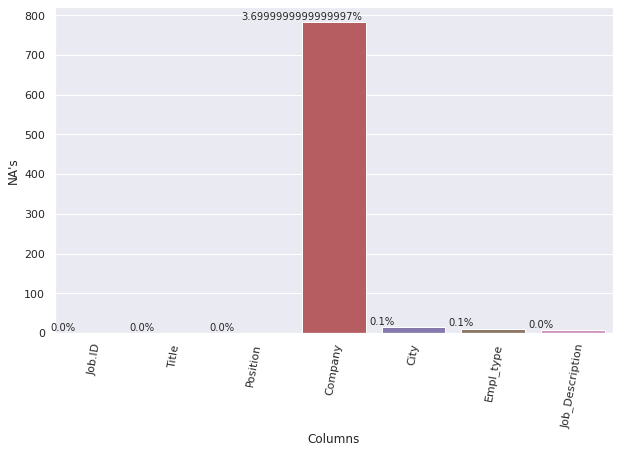

In [7]:
# Plotting NA's

x = df_new.columns
y = df_new.isnull().sum()
plt.figure(figsize=(10,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(),
            height + 2,
            str(100*round(int(height)/df_new.shape[0], 3)) +"%",
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("NA's")
plt.xticks(rotation=80)

plt.show()

In [8]:
# selecting NaN rows of city 
df_nan_city = df_new[pd.isnull(df_new['City'])]
print(df_nan_city.shape)
df_nan_city.head()

(14, 7)


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
3425,142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...
3433,142054,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."


In [9]:
df_nan_city.groupby(['Company'])['City'].count() 

Company
CHI Payment Systems       0
Driveline Retail          0
Genesis Health Systems    0
St. Francis Hospital      0
Name: City, dtype: int64

**We see that there are only 9 companies cities that are having NaN values so it must be manually adding their head quarters (by simply searching at google)**

In [10]:
#replacing nan with thier headquarters location
df_new['Company'] = df_new['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')
df_new.loc[df_new.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
df_new.loc[df_new.Company == 'Academic Year In America', 'City'] = 'Stamford'
df_new.loc[df_new.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
df_new.loc[df_new.Company == 'Driveline Retail', 'City'] = 'Coppell'
df_new.loc[df_new.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
df_new.loc[df_new.Company == 'Genesis Health System', 'City'] = 'Davennport'
df_new.loc[df_new.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
df_new.loc[df_new.Company == 'St. Francis Hospital', 'City'] = 'New York'
df_new.loc[df_new.Company == 'Volvo Group', 'City'] = 'Washington'
df_new.loc[df_new.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [11]:
df_new.isnull().sum()

Job.ID               0
Title                0
Position             0
Company            782
City                 0
Empl_type           11
Job_Description      7
dtype: int64

In [12]:
#The employement type NA are from Uber so I assume as part-time and full time
df_nan_emp = df_new[pd.isnull(df_new['Empl_type'])]
df_nan_emp.head()

,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
10768,153197,Driving Partner @ Uber,Driving Partner,Uber,San Francisco,NaN,Uber is changing the way the world moves. From...
10769,153198,Driving Partner @ Uber,Driving Partner,Uber,Los Angeles,NaN,Uber is changing the way the world moves. From...
10770,153199,Driving Partner @ Uber,Driving Partner,Uber,Chicago,NaN,Uber is changing the way the world moves. From...
10771,153200,Driving Partner @ Uber,Driving Partner,Uber,Boston,NaN,Uber is changing the way the world moves. From...
10772,153201,Driving Partner @ Uber,Driving Partner,Uber,Ann Arbor,NaN,Uber is changing the way the world moves. From...


In [13]:
df_new['Empl_type'].unique()

array(['Part-Time', 'Full-Time/Part-Time', 'Seasonal/Temp', 'Per Diem',
       'Intern', nan, 'Full-Time', 'Contract', None], dtype=object)

In [14]:
#replacing na values with part time/full time
df_new['Empl_type']=df_new['Empl_type'].fillna('Full-Time/Part-Time')
df_new.groupby(['Empl_type'])['Company'].count()
df_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


# Creating Job Corpus
Combining the columns of position, company, city, emp_type and position

In [15]:
df_new["text"] = df_new["Position"].map(str) + " " + df_new["Company"] +" "+ df_new["City"]+ " "+df_new['Empl_type']+" "+df_new['Job_Description'] +" "+df_new['Title']
df_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Job.ID,Title,Position,Company,City,Empl_type,Job_Description,text
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...,Server Tacolicious Palo Alto Part-Time Tacolic...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...,Kitchen Staff/Chef Claude Lane San Francisco P...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...,Bartender Machka Restaurants Corp. San Francis...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...,Server Teriyaki House Brisbane Part-Time ● Se...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ...",Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...


In [16]:
df_all = df_new[['Job.ID', 'text', 'Title']]
df_all = df_all.fillna(" ")
df_all.head()

,Job.ID,text,Title
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset


In [17]:
df_all.shape

(21292, 3)

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

**Cleaning the job corpus**

In [20]:
df_all['text'] = df_all['text'].apply(clean_txt)

**TF-IDF ( Term Frequency - Inverse Document Frequency )**

In [21]:
#initializing tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
tfidf_jobid

<21292x26756 sparse matrix of type '<class 'numpy.float64'>'
	with 2043162 stored elements in Compressed Sparse Row format>

# Cretating the User Corpus
Job views dataset

In [22]:
df_job_view = pd.read_csv("Job_Views.csv" , engine='python', error_bad_lines=False)
df_job_view.head()

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC


**In this case we will use only the columns 'Applicant.ID', 'Job.ID', 'Position', 'Company','City'**

In [23]:
df_job_view = df_job_view[['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
df_job_view["select_pos_com_city"] = df_job_view["Position"].map(str) + "  " + df_job_view["Company"] +"  "+ df_job_view["City"]
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].map(str).apply(clean_txt)
df_job_view['select_pos_com_city'] = df_job_view['select_pos_com_city'].str.lower()
df_job_view = df_job_view[['Applicant.ID','select_pos_com_city']]
df_job_view.head()

,Applicant.ID,select_pos_com_city
0,10000,cashier valet need wallypark newark
1,10000,macys seasonal retail fragrance cashier garden...
2,10001,part time showroom sales cashier grizzly indus...
3,10002,event specialist part time advantage sales mar...
4,10002,bonefish kitchen staff bonefish grill greenville


**Experience dataset**

In [24]:
df_experience = pd.read_csv("Experience.csv" , engine='python', error_bad_lines=False)
df_experience.head()

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC


In [25]:
#taking only Position
df_experience= df_experience[['Applicant.ID','Position.Name']]
#cleaning the text
df_experience['Position.Name'] = df_experience['Position.Name'].map(str).apply(clean_txt)
df_experience.head()

,Applicant.ID,Position.Name
0,10001,account manager sales administration quality a...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper


In [26]:
df_experience =  df_experience.sort_values(by='Applicant.ID')
df_experience = df_experience.fillna(" ")
df_experience.head()

,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer uloop blog
3759,3,market intern
3758,3,server
3757,3,prep cook


**Same applicant has 3 applications 100001 in sigle line so we need to join them**

In [27]:
#adding same rows to a single row
df_experience = df_experience.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
df_experience.head()

,Applicant.ID,Position.Name
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


**Position of Interest dataset**

In [28]:
df_poi =  pd.read_csv("Positions_Of_Interest.csv", sep=',', engine='python', error_bad_lines=False)
df_poi = df_poi.sort_values(by='Applicant.ID')
df_poi.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [29]:
df_poi = df_poi.drop('Updated.At', 1)
df_poi = df_poi.drop('Created.At', 1)

#cleaning the text
df_poi['Position.Of.Interest']=df_poi['Position.Of.Interest'].map(str).apply(clean_txt)
df_poi = df_poi.fillna(" ")
df_poi.head()

,Applicant.ID,Position.Of.Interest
6437,96,server
1156,153,barista
1155,153,host
1154,153,server
1158,153,sales rep


In [30]:
df_poi = df_poi.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
df_poi.head()

,Applicant.ID,Position.Of.Interest
0,96,server
1,153,barista host server sales rep customer service...
2,256,host production area sales rep customer servic...
3,438,customer service rep barista host server
4,568,receptionist customer service rep book keeper


# Creating the final user dataset by merging all the users datasets


In [31]:
# Merging jobs and experience dataframes
df_jobs_exp = df_job_view.merge(df_experience, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp = df_jobs_exp.fillna(' ')
df_jobs_exp = df_jobs_exp.sort_values(by='Applicant.ID')
df_jobs_exp.head()

,Applicant.ID,select_pos_com_city,Position.Name
12370,2,,volunteer writer uloop blog
12371,3,,market intern server prep cook
12372,6,,project assistant
12373,8,,deli clerk server cashier food prep order taker
12374,11,,cashier


In [32]:
# Merging position of interest with existing dataframe
df_jobs_exp_poi = df_jobs_exp.merge(df_poi, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
df_jobs_exp_poi = df_jobs_exp_poi.fillna(' ')
df_jobs_exp_poi = df_jobs_exp_poi.sort_values(by='Applicant.ID')
df_jobs_exp_poi.head()

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest
0,2,,volunteer writer uloop blog,
1,3,,market intern server prep cook,
2,6,,project assistant,
3,8,,deli clerk server cashier food prep order taker,
4,11,,cashier,


In [33]:
# combining all the columns
df_jobs_exp_poi["text"] = df_jobs_exp_poi["select_pos_com_city"].map(str) + df_jobs_exp_poi["Position.Name"] +" "+ df_jobs_exp_poi["Position.Of.Interest"]
df_jobs_exp_poi.head()

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest,text
0,2,,volunteer writer uloop blog,,volunteer writer uloop blog
1,3,,market intern server prep cook,,market intern server prep cook
2,6,,project assistant,,project assistant
3,8,,deli clerk server cashier food prep order taker,,deli clerk server cashier food prep order tak...
4,11,,cashier,,cashier


In [34]:
# Select only "Applicant.ID" and "text" columns:
df_final_person= df_jobs_exp_poi[['Applicant.ID','text']]
df_final_person.head()

,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [35]:
df_final_person.columns = ['Applicant_id','text']
df_final_person.head()

,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [36]:
df_final_person['text'] = df_final_person['text'].apply(clean_txt)
df_final_person.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Applicant_id,text
0,2,volunteer writer uloop blog
1,3,market intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


**To test the recommender we select the user which ID is 326**

In [37]:
u = 326
index = np.where(df_final_person['Applicant_id'] == u)[0][0]
user_q = df_final_person.iloc[[index]]
user_q

,Applicant_id,text
186,326,java developer


# The recommender system
Computing cosine similarity using tfidf

In [38]:
user_tfidf = tfidf_vectorizer.transform(user_q['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)

In [39]:
output2 = list(cos_similarity_tfidf)

**Function to get the top-N recomendations order by score**

In [40]:
def get_recommendation(top, df_all, scores):
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID',  'title', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = u
      recommendation.at[count, 'JobID'] = df_all['Job.ID'][i]
      recommendation.at[count, 'title'] = df_all['Title'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

**The top recommendations using TF-IDF**

In [41]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.675608
1,326,245753,Java Administrator @ ConsultNet,0.534719
2,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.510373
3,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.486321
4,326,243777,Java Developer @ Mindteck,0.434502
5,326,246871,Java Developer @ Mindteck,0.397203
6,326,250354,Web Developer (Long Term Freelance) @ Creativ...,0.340441
7,326,244411,Sr. .Net Developer @ Staffing Solutions Enterp...,0.306551
8,326,250351,UI Developer (Mid - Junior Level) @ Sharp Deci...,0.275153
9,326,250216,Microstrategy Developer @ Kavaliro,0.270758


**Using Count Vectorizer**

In [42]:
count_vectorizer = CountVectorizer()
count_jobid = count_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
count_jobid

<21292x26756 sparse matrix of type '<class 'numpy.int64'>'
	with 2043162 stored elements in Compressed Sparse Row format>

In [43]:
user_count = count_vectorizer.transform(user_q['text'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)
output2 = list(cos_similarity_countv)

**The top recommendations using CountVectorizer**

In [44]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,141831,Lead Java/J2EE Developer - Contract to Hire @ ...,0.496907
1,326,245753,Java Administrator @ ConsultNet,0.378968
2,326,150882,Java Consultant - Mobile Apps Development @ Co...,0.363216
3,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.323381
4,326,250216,Microstrategy Developer @ Kavaliro,0.312772
5,326,246871,Java Developer @ Mindteck,0.291999
6,326,243777,Java Developer @ Mindteck,0.291692
7,326,250354,Web Developer (Long Term Freelance) @ Creativ...,0.283069
8,326,244411,Sr. .Net Developer @ Staffing Solutions Enterp...,0.241747
9,326,176634,Salesforce Developer @ Employ-R Solutions,0.201347


**Recommendation using Spacy**


**Transform the corpus text to the spacy's documents**

In [45]:
#!python -m spacy download en_core_web_lg

In [46]:
nlp = spacy.load('en_core_web_lg')

In [47]:
%%time
list_docs = []
for i in range(len(df_all)):
  doc = nlp("u'" + df_all['text'][i] + "'")
  list_docs.append((doc,i))
print(len(list_docs))

21292
CPU times: user 9min 20s, sys: 6.21 s, total: 9min 26s
Wall time: 9min 26s


In [48]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim   

In [49]:
user_q.text[186]

'java developer'

In [50]:
%%time
df3 = calculateSimWithSpaCy(nlp, df_all, user_q.text[186], n=15)

CPU times: user 19.3 s, sys: 834 ms, total: 20.1 s
Wall time: 18.7 s


In [51]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head()

In [52]:
df_recom_spacy.reset_index(inplace=True)

In [53]:
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

**The top recommendation using Spacy**

In [54]:
get_recommendation(index_spacy, df_all, list_scores)

,ApplicantID,JobID,title,score
0,326,250216,Microstrategy Developer @ Kavaliro,0.698317
1,326,150873,Engineering Intern,0.633758
2,326,147967,Personal Care Aide,0.633758
3,326,151161,Extended Day Assistants!,0.633758
4,326,175566,T-Mobile Sales Representative,0.633758


**Using KNN**

In [55]:
from sklearn.neighbors import NearestNeighbors
KNN = NearestNeighbors(n_neighbors = 10, p=2)
KNN.fit(tfidf_jobid)
NNs = KNN.kneighbors(user_tfidf, return_distance=True)  

In [56]:
NNs[0][0][1:]

array([0.96465647, 0.98957238, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

**The top recommendations using KNN**

In [57]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]
get_recommendation(top, df_all, index_score)

,ApplicantID,JobID,title,score
0,326,245753,Java Administrator @ ConsultNet,0.964656
1,326,146640,Jr. Java Developer @ Paladin Consulting Inc,0.989572
2,326,144457,Retail Sales Associate – Part-Time,1
3,326,144455,T-Mobile Sales Representative,1
4,326,144456,T-Mobile Sales Representative,1
5,326,144453,T-Mobile Sales Representative,1
6,326,144458,T-Mobile Sales Representative,1
7,326,144451,T-Mobile Sales Representative,1
8,326,144459,Technology Sales Specialist,1
